# 微调树的参数：max_depth & min_child_weight
(微调，将步长降为1，进行精细调整)

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
# train.head()

## 准备数据

In [3]:
y_train = train['interest_level']

train = train.drop(['interest_level'], axis=1, inplace = False)
X_train = train

In [4]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
from sklearn.model_selection import train_test_split
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.2,random_state = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
X_train_part.shape

(9870, 227)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [6]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [7]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = [5,6,7]
min_child_weight = [2,3,4]
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': [5, 6, 7], 'min_child_weight': [2, 3, 4]}

In [8]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=104,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.5,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=5)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train_part , y_train_part)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.62865, std: 0.00864, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.62768, std: 0.00826, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.62724, std: 0.00866, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.62690, std: 0.01005, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -0.62656, std: 0.00769, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.62853, std: 0.00859, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.63002, std: 0.00752, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: -0.62977, std: 0.00992, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.62699, std: 0.00818, params: {'max_depth': 7, 'min_child_weight': 4}],
 {'max_depth': 6, 'min_child_weight': 3},
 -0.6265610097718766)

In [9]:
gsearch2_1.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([47.21908426, 47.57034392, 47.62739091, 57.16448946, 56.63968391,
        56.35644078, 65.88156099, 65.66553898, 61.4641778 ]),
 'std_fit_time': array([0.69408801, 0.18221418, 0.40191011, 0.13055601, 0.21718194,
        0.22333585, 0.28585056, 0.18201926, 5.62605405]),
 'mean_score_time': array([0.09315171, 0.09255433, 0.09434948, 0.1095088 , 0.11110411,
        0.11170177, 0.12307167, 0.12347054, 0.10731454]),
 'std_score_time': array([0.00249144, 0.00074559, 0.00401899, 0.00443233, 0.00982422,
        0.0066165 , 0.00162024, 0.00540435, 0.0112588 ]),
 'param_max_depth': masked_array(data=[5, 5, 5, 6, 6, 6, 7, 7, 7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_val

Best: -0.626561 using {'max_depth': 6, 'min_child_weight': 3}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\dep

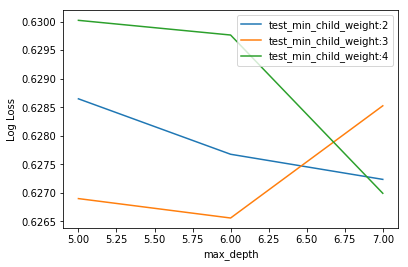

In [13]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(min_child_weight):
    pyplot.plot(max_depth, -test_scores[i], label= 'test_min_child_weight:'   + str(value))
# for i, value in enumerate(min_child_weight):
#     pyplot.plot(max_depth, -train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )

当前调参结果：  
最优max_depth为6；   
最优min_child_weight为3。